In [1]:
import numpy as np
import nibabel as nib
from nilearn.plotting import plot_surf_stat_map
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import ciftools_af as ct
import seaborn as sns


def tri_space(rgb):
    rgb = (rgb - rgb.min(keepdims=True)) / (rgb.max(keepdims=True) - rgb.min(keepdims=True)) # all values between 0 and 1    
    rgb = 1-rgb # inversion
    rgb = rgb + rgb.std()/100000 # eliminate 0 values
    rgb = rgb/rgb.sum(axis=1,keepdims=True)    # convert values to that sum=1
    x = (rgb[:,2] - rgb[:,0])/np.sqrt(3)
    y = rgb[:,1]
    xy = np.array([x,y])
    rgb = (1/rgb.max(axis=1,keepdims=True))*rgb
    return rgb, xy

def plot_tri_space(xy, c='k', s=80, marker='o', alpha=.75, labels=['R','G','B'], grid_c='gray', cmap='viridis'):
    sns.set_style('white')
    rgb_0, xy_0 = tri_space(np.array([[0,1,1],[1,0,1],[1,1,0]]))
    xy_0 = np.hstack([xy_0, xy_0[:,0:1]])
    axes = np.array([[xy_0[0,0], 0, xy_0[0,1], 0, xy_0[0,2]],
                 [xy_0[1,0], 1/3, xy_0[1,1], 1/3, xy_0[1,2]]])
    # plot grid
    plt.plot(xy_0[0], xy_0[1], c=grid_c)
    plt.plot(axes[0], axes[1], ':',c=grid_c)
    # plot rgb values
    plt.scatter(xy[0], xy[1], c=c, s=s, marker=marker, alpha=alpha, cmap=cmap)
    # set labels
    plt.text(xy_0[0,0], xy_0[1,0], labels[0], size=15, color=grid_c, horizontalalignment='right', verticalalignment='top')
    plt.text(xy_0[0,1], xy_0[1,1], labels[1], size=15, color=grid_c, horizontalalignment='center', verticalalignment='bottom')
    plt.text(xy_0[0,2], xy_0[1,2], labels[2], size=15, color=grid_c, horizontalalignment='left', verticalalignment='top')
    # refine
    plt.xticks([])
    plt.yticks([])
    plt.box()


### VARIABLES TO SET BEFORE RUNNING
# directory containing subdirectories named fter subject IDs that contain the timeseries and surface files
root_dir = "/home/fralberti/Data/HCP/"
# directory where all intermediate files and the final output will be saved
output_dir = "/home/fralberti/Data/Output_misc/"
# list of IDs of subjects to include in the analyses
f = open(f'{root_dir}subj_IDs_200.txt', 'r')
subj_id = np.array(f.read().splitlines())
del f

/home/fralberti/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


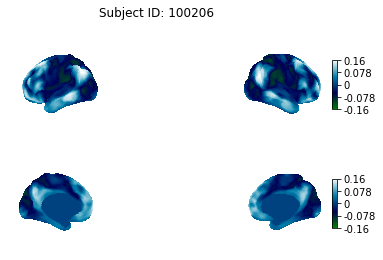

In [3]:
cmap='ocean'
for subj in subj_id[0:1]:
    grad1 = nib.load(f'{root_dir}{subj}/{subj}.gcca_200.32k_fs_LR.dscalar.nii')
    fig, axs = plt.subplots(2, 2, figsize=(7,4), subplot_kw={'projection':'3d'}, sharey=True)
    
    for i, hemi in enumerate(['L','R']):
        hemisphere = ['left','right']
        surf = nib.load(f'{root_dir}{subj}/Structural/{subj}.{hemi}.inflated_MSMAll.32k_fs_LR.surf.gii')
        
        idx_count = grad1.header.get_index_map(1)[i].index_count
        idx_offset = grad1.header.get_index_map(1)[i].index_offset
        vtx_indices = grad1.header.get_index_map(1)[i].vertex_indices[0:]
        stat_map = np.zeros(surf.agg_data()[0].shape[0])
        stat_map[vtx_indices] = np.array(grad1.get_fdata().squeeze()[0,idx_offset:idx_offset+idx_count])

        plot_surf_stat_map(f'{root_dir}{subj}/Structural/{subj}.{hemi}.inflated_MSMAll.32k_fs_LR.surf.gii',
                           stat_map, hemi=hemisphere[i], axes=axs[0,i], colorbar=i, cmap=cmap)
        plot_surf_stat_map(f'{root_dir}{subj}/Structural/{subj}.{hemi}.inflated_MSMAll.32k_fs_LR.surf.gii',
                           stat_map, hemi=hemisphere[i], view='medial', axes=axs[1,i],colorbar=i,cmap=cmap)
        fig.suptitle('Subject ID: %s' % subj, fontsize=12)
                
        del surf
    del grad1

Text(0, 0.5, 'subject')

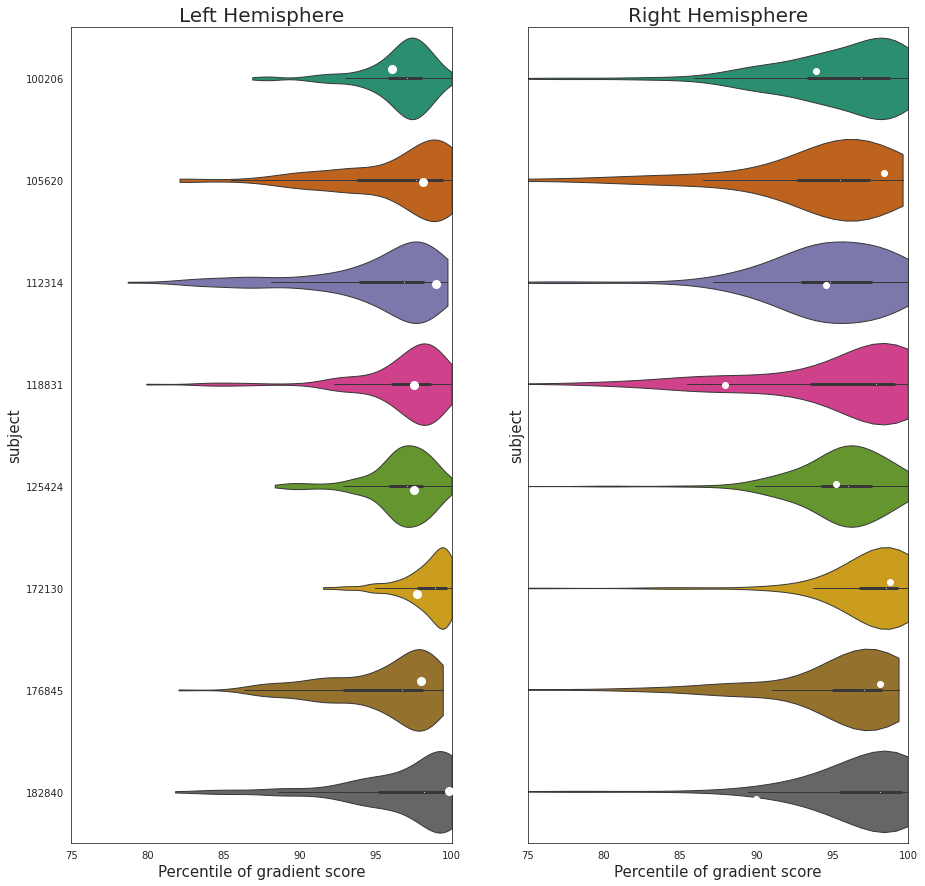

In [10]:
sns.set_style('white')

gradientile_df = pd.read_csv(f'{output_dir}gradientiles_200.csv')[['ID_vtx','ID_grad','hemisphere','percentile','mean']]
gradientile_df = gradientile_df[gradientile_df.ID_grad.isin(gradientile_df.ID_grad.unique()[0:200:25])]

perms = gradientile_df[gradientile_df.ID_grad != gradientile_df.ID_vtx]
real = gradientile_df[gradientile_df.ID_grad == gradientile_df.ID_vtx]


fig, axs = plt.subplots(1,2,figsize=[15,15],sharey=True)
axs[0].set_title('Left Hemisphere', fontsize=20)
axs[1].set_title('Right Hemisphere', fontsize=20)

# ### LEFT
x = 'percentile'
y = 'ID_grad'
sns.violinplot(x=x,y=y,data=perms[perms.hemisphere=='L'],ax=axs[0],
              marker='.',linewidth=1, orient='h', cut=0,palette='Dark2', scale='width')
# sns.stripplot(x=x,y=y,data=perms[perms.hemisphere=='L'],ax=axs[0],
#               marker='.',linewidth=0, orient='h', size=4, alpha=1, color='k')
sns.stripplot(x=x,y=y,data=real[real.hemisphere=='L'],ax=axs[0],
              marker='o', linewidth=1, orient='h',size=8, edgecolor='white',color='w')
axs[0].set_xlim([75,100])
axs[0].set_xlabel('Percentile of gradient score', fontsize=15)
axs[0].set_ylabel('subject', fontsize=15)
### RIGHT
sns.violinplot(x=x,y=y,data=perms[perms.hemisphere=='R'],ax=axs[1],
              marker='.',linewidth=1, orient='h', cut=0,palette='Dark2', scale='width')
# sns.stripplot(x=x,y=y,data=perms[perms.hemisphere=='R'],ax=axs[1],
#               marker='.',linewidth=0, orient='h', size=4, alpha=1, color='k')
sns.stripplot(x=x,y=y,data=real[real.hemisphere=='R'],ax=axs[1],
              marker='o', linewidth=1, orient='h',size=6, edgecolor='white',color='w')
axs[1].set_xlim([75,100])
axs[1].set_xlabel('Percentile of gradient score', fontsize=15)
axs[1].set_ylabel('subject', fontsize=15)


In [29]:
# prepare data for polar plot and triangular plot

peaks_df = pd.read_csv(f'{output_dir}grad1_lPAR_peaks.csv')
peaks_df = peaks_df[['ID','hemisphere','peak']]
ints_df = pd.read_csv(f'{output_dir}gradientiles_200.csv')
ints_df = ints_df[ints_df.ID_vtx==ints_df.ID_grad][['ID_vtx','hemisphere', 'vertex1', 'vertex2', 'vertex3']]
rgb_df = pd.DataFrame(columns=['ID','hemi','peak','magn','angle','calc','cs','tt'])
vector_df = pd.read_csv(f'{output_dir}vect_to_peak.csv',usecols=['ID','hemisphere','distance','angle'])

for subj in subj_id:
    dist = nib.load(f'/home/fralberti/Data/HCP/{subj}/Structural/{subj}.gdist_prim.32k_fs_LR.dscalar.nii')
    dist_rgb = dist.get_fdata().T
    for hemi in ['L','R']:
        brain_structure = ('CIFTI_STRUCTURE_CORTEX_LEFT' if hemi=='L' else 'CIFTI_STRUCTURE_CORTEX_RIGHT')
        brain_model = ct.struct_to_bm(brain_structure, dist)
        offset, count, vertices = ct.struct_info(brain_structure, dist)
        
        rgb = dist_rgb[offset:offset+count,:]
        
        subj_peaks = peaks_df.loc[peaks_df.ID==int(subj)]
        peak = peaks_df.loc[peaks_df.hemisphere==hemi, 'peak'].values[0]
        ints = ints_df.loc[(ints_df.ID_vtx==int(subj)) & (ints_df.hemisphere==hemi),['vertex1','vertex2','vertex3']].values[0]
        
        peak_dist = np.array(rgb[np.isin(vertices,peak)])[0]
        ints_dist = np.array(rgb[np.isin(vertices,ints)]).mean(axis=0)
        rgb_tmp = peak_dist #- ints_dist
        
        magn_angle = vector_df.loc[(vector_df.ID==int(subj)) & (vector_df.hemisphere==hemi),['distance','angle']].values[0]
        rgb = pd.DataFrame([[subj, hemi, peak, magn_angle[0], magn_angle[1], rgb_tmp[2], rgb_tmp[3], rgb_tmp[4]]],
                                    columns=['ID','hemi','peak','magn','angle','calc','cs','tt'])
        rgb_df = pd.concat([rgb_df, rgb])
rgb_df.reset_index(inplace=True, drop=True)
rgb_df.head()

,ID,hemi,peak,magn,angle,calc,cs,tt
0,100206,L,16438,14.680964,3.204511,116.840492,89.545006,75.887718
1,100206,R,16293,12.531686,4.9448,110.896942,100.521172,82.614731
2,100307,L,16438,31.438694,4.191786,99.158371,92.514442,61.974171
3,100307,R,16293,2.948666,5.317232,98.50222,95.883247,83.974007
4,100408,L,16438,18.993999,3.304725,106.732124,89.251564,74.611694


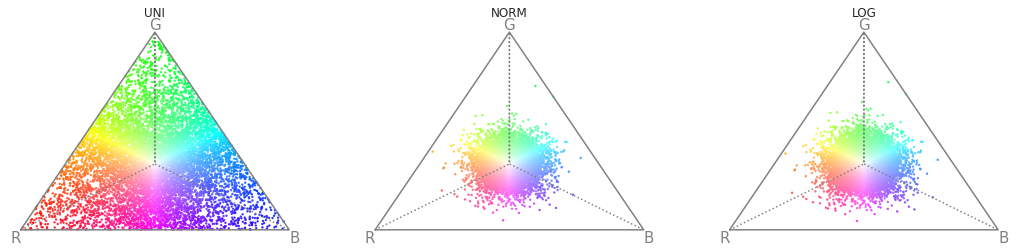

In [32]:
sns.set_style('dark')
x_uni = np.random.uniform(1,2,[10000,3])
x_norm = np.random.normal(10,.5,[10000,3])
x_log = np.log(x_norm)


f = plt.figure(figsize=[18,4])
f.add_subplot(131,title='UNI')
rgb, xy = tri_space(x_uni)
plot_tri_space(xy,c=rgb,s=2,marker='o')
f.add_subplot(132,title='NORM')
rgb, xy = tri_space(x_norm)
plot_tri_space(xy,c=rgb,s=2,marker='o')
f.add_subplot(133,title='LOG')
rgb, xy = tri_space(x_log)
plot_tri_space(xy,c=rgb,s=2,marker='o')

Text(0.5, 1.0, 'Right')

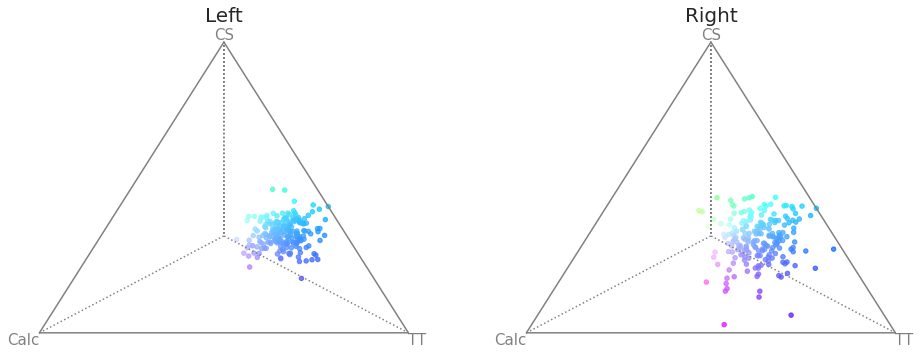

In [30]:
# Plot peak shifts
cmap = sns.color_palette('Dark2',2)

fig = plt.figure(figsize=[16,20])

sns.set_style('dark')

fig.add_subplot(321)
rgb_L, xy_L =tri_space(np.array(rgb_df.loc[rgb_df.hemi=='L', ['calc','cs','tt']]))
plot_tri_space(xy_L, c=rgb_L, s=20, alpha=.75, labels=['Calc','CS','TT'], grid_c='grey')
plt.title('Left', fontsize=20)

fig.add_subplot(322, title='Right')
rgb_R, xy_R =tri_space(np.array(rgb_df.loc[rgb_df.hemi=='R', ['calc','cs','tt']]))
plot_tri_space(xy_R, c=rgb_R, s=20, alpha=.75, labels=['Calc','CS','TT'], grid_c='grey')
plt.title('Right', fontsize=20)



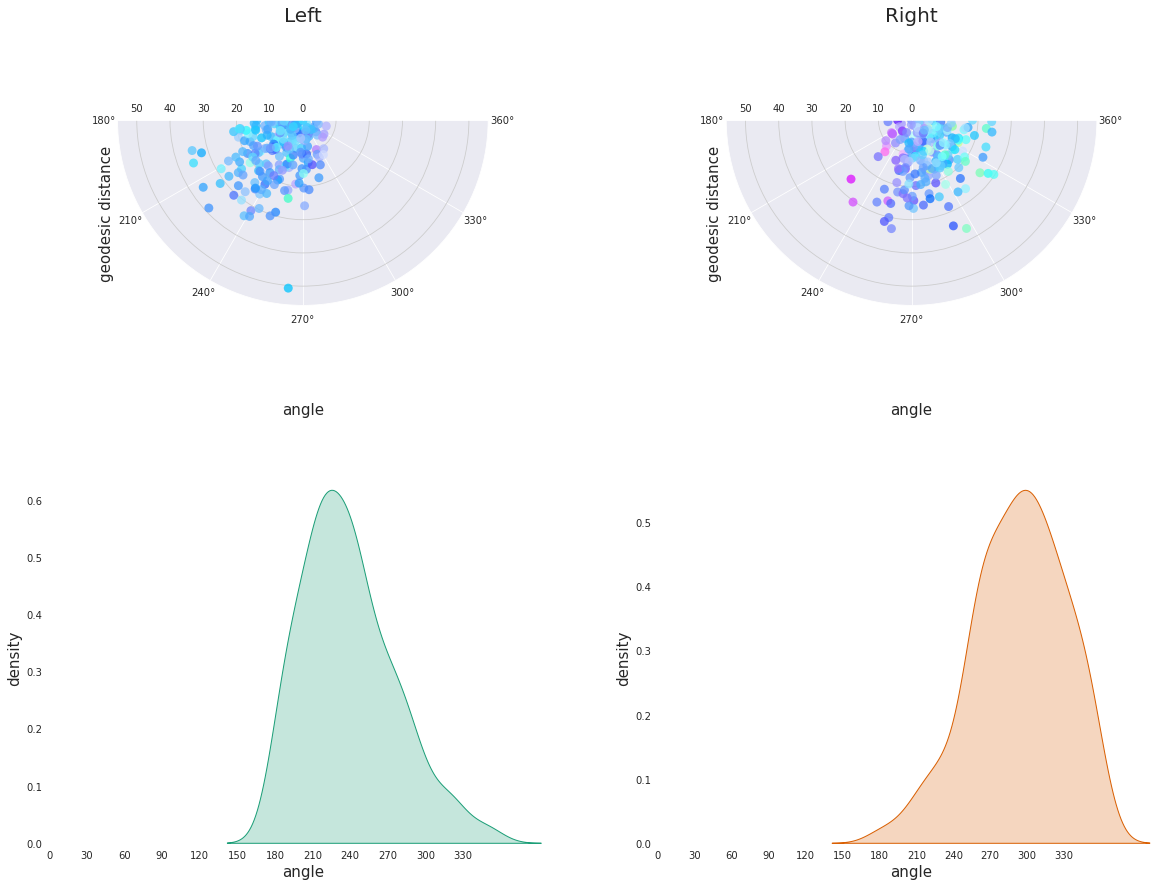

In [20]:
fig = plt.figure(figsize=[20,15])
cmap = sns.color_palette('Dark2',2)

sns.set_style('darkgrid')

fig.add_subplot(221, projection='polar')
plt.ylim([0,rgb_df.magn.max()+5])
plt.xlim([np.deg2rad(180), np.deg2rad(360)])
ax = sns.scatterplot(data=rgb_df[rgb_df.hemi=='L'], x='angle',y='magn', c=rgb_L, s=80, alpha=.75, linewidth=0)
ax.set_title(r"Left", size=20)
ax.set_xlabel(r"angle", size=15)
ax.set_ylabel("geodesic distance", size=15)

fig.add_subplot(222, projection='polar')
plt.ylim([0,rgb_df.magn.max()+5])
plt.xlim([np.deg2rad(180), np.deg2rad(360)])
ax = sns.scatterplot(data=rgb_df[rgb_df.hemi=='R'], x='angle',y='magn', c=rgb_R, s=80, alpha=.75, linewidth=0)
ax.set_title(r"Right", size=20)
ax.set_xlabel(r"angle", size=15)
ax.set_ylabel("geodesic distance", size=15)


sns.set_style('white')

fig.add_subplot(223)
ax = sns.kdeplot(data=rgb_df[rgb_df.hemi=='L'], x='angle', fill=True, color=cmap[0])
_ = plt.xticks(ticks=np.deg2rad(np.arange(0,360,30)), labels=np.arange(0,360,30))
ax.set_xlabel(r"angle", size=15)
ax.set_ylabel("density", size=15)
plt.box()

fig.add_subplot(224)
ax = sns.kdeplot(data=rgb_df[rgb_df.hemi=='R'], x='angle', fill=True, color=cmap[1])
_ = plt.xticks(ticks=np.deg2rad(np.arange(0,360,30)), labels=np.arange(0,360,30))
ax.set_xlabel(r"angle", size=15)
ax.set_ylabel("density", size=15)
plt.box()
